In [1]:
# Date: 28/05/2021
# Author: Joshua Soutelo Vieira

In [7]:
import os
import json

import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
DATA_FOLDER = "data"
OUTPUT_FOLDER = "output"

In [8]:
def show_image(image, name=None):
    plt.title(name)
    plt.xlabel(str(image.shape[1]) + " px")
    plt.ylabel(str(image.shape[0]) + " px")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def grab_fields_coords(file):
    with open(file, "r") as f:
        content = json.loads(f.read())

    return content    

In [18]:
# Gray scale image + Tresholding => B&W image
def bw(image, threshold=None, show=False):
    # First transform the image to gray scale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Sometimes we choose to set the threshold manually assuming that the Otsu algorithm wasn't unable to find a proper one
    if threshold:
        (thresh, bw_img) = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY_INV)
    else:
        # Treshold set to -0 to point out that it's Otsu's algorithm job to decide it
        (thresh, bw_img) = cv2.threshold(gray_img, -0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    if show:
        show_image(gray_img, "Gray scale")
        show_image(bw_img, "Trehshold (B&W)")
    
    return bw_img

In [23]:
# Gaussian Blur
def gauss_blur(image, show=False):
    
    gauss_img = cv2.GaussianBlur(
        src=image,
        ksize=(3,3),
        sigmaX=.5)
    
    if show: show_image(gauss_img, "Gaussian Blur")
    
    return gauss_img

In [106]:
"""
 It coalesces rectangles until we end up with the outmost rectangle. It only takes into account rectangles that
 are at least 
"""
# ROI Extraction
def roi(bw_img, gauss_img, rect_thresh=3, show=False):
    
    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    if len(rects) == 1: # Only one contour found
        x, y, w, h = rects[0]
    
    else:
        # This approach coalesces rectangles in a way that we end up with the outmost ROI
        x, y, w, h = (None, None, None, None)
        for r in rects:
            # Unpack elements
            x1, y1, w1, h1 = r
            # If the width or height of the rectangle passes a threshold value
            if w1 >= rect_thresh and h1 >= rect_thresh:
                if x != None and y != None and w != None and h != None:
                    # We have to take that x or y that is closer to the origin
                    if x1 < x:
                        x_tmp = x1
                    else:
                        x_tmp = x
                    if y1 < y:
                        y_tmp = y1
                    else:
                        y_tmp = y
                    # We have to compute the new width and height with respect of the outer x and y
                    if x1 + w1 > x + w:
                        w_tmp = (x1 + w1) - x_tmp
                    else:
                        w_tmp = (x + w) - x_tmp
                    if y1 + h1 > y + h:
                        h_tmp = (y1 + h1) - y_tmp
                    else:
                        h_tmp = (y + h) - y_tmp
                    # Update the outmost ROI
                    x, y, w, h = x_tmp, y_tmp, w_tmp, h_tmp
                else:
                    x, y, w, h = r
        # We didn't find a proper rectangle. Assing the one with smallest width or height so we assure that 
        # the thresholding algorithm will run again with a manual value
        if x == None and y == None and w == None and h == None:
            x, y, w, h = rects[0]
            for r in rects[1:]:
                x1, y1, w1, h1 = r
                if w1 < w or h1 < h:
                    x, y, w, h = r
    """
    for r in rects:
        x1, y1, w1, h1 = r
        show_image(gauss_img[y1:y1+h1, x1:x1+w1])
    """
    
    roi = gauss_img[y:y+h, x:x+w]
    
    if show: show_image(roi, "ROI")
    
    return roi

WRITEUP NO. 120 60 141 29


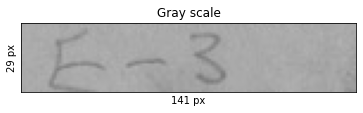

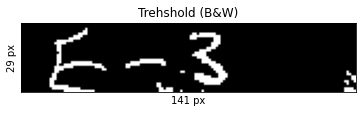

[(76, 28, 1, 1), (67, 28, 1, 1), (136, 27, 5, 2), (57, 25, 7, 4), (136, 24, 2, 2), (137, 20, 4, 5), (67, 20, 2, 1), (44, 15, 17, 4), (71, 4, 16, 22), (12, 2, 24, 27)]


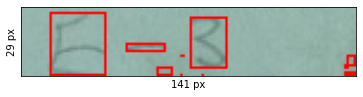

PHOTO NO. 968 68 136 28


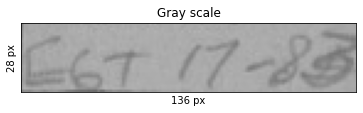

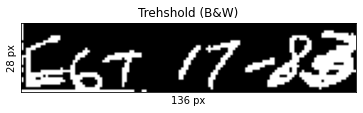

[(49, 27, 2, 1), (0, 22, 1, 2), (0, 18, 1, 2), (91, 14, 12, 6), (33, 11, 16, 15), (64, 9, 9, 14), (0, 8, 1, 3), (75, 7, 14, 20), (100, 5, 18, 21), (0, 5, 46, 23), (113, 3, 23, 24), (0, 0, 1, 7)]


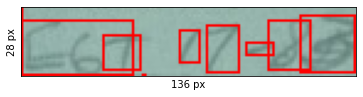

FOREST 120 109 195 27


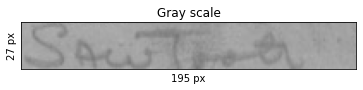

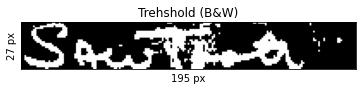

[(95, 21, 2, 2), (173, 16, 1, 1), (81, 16, 1, 2), (97, 15, 2, 3), (57, 13, 2, 1), (97, 12, 1, 1), (173, 11, 1, 3), (31, 10, 49, 17), (184, 9, 3, 3), (176, 9, 1, 2), (170, 9, 2, 2), (115, 6, 1, 1), (170, 5, 1, 1), (113, 1, 3, 2), (100, 1, 1, 1), (168, 0, 1, 2), (138, 0, 5, 2), (135, 0, 2, 1), (66, 0, 99, 27), (85, 0, 3, 1), (2, 0, 25, 27)]


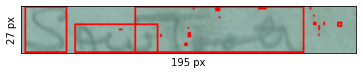

RANGER DISTRICT 319 109 231 31


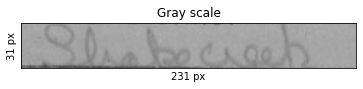

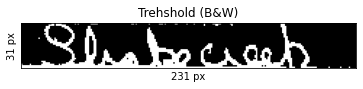

[(226, 30, 1, 1), (220, 30, 1, 1), (212, 30, 1, 1), (12, 10, 1, 1), (144, 0, 2, 2), (132, 0, 6, 2), (126, 0, 1, 2), (119, 0, 1, 1), (114, 0, 1, 1), (106, 0, 2, 1), (99, 0, 1, 1), (95, 0, 3, 1), (88, 0, 1, 1), (79, 0, 1, 1), (76, 0, 2, 1), (48, 0, 5, 1), (39, 0, 1, 1), (37, 0, 1, 1), (0, 0, 204, 31)]


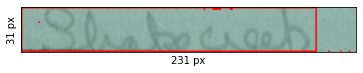

ALLOTMENT 555 113 266 27


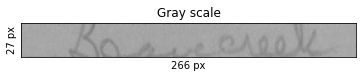

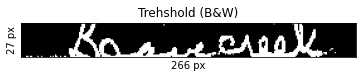

[(34, 26, 2, 1), (31, 26, 1, 1), (25, 26, 1, 1), (23, 26, 1, 1), (16, 26, 1, 1), (13, 26, 1, 1), (7, 26, 2, 1), (4, 26, 2, 1), (27, 25, 2, 2), (249, 23, 1, 1), (245, 20, 3, 2), (113, 1, 1, 1), (156, 0, 87, 27), (200, 0, 2, 1), (38, 0, 117, 27)]


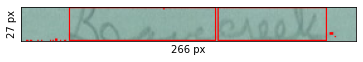

EXAMINER 825 115 173 27


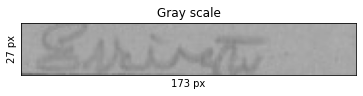

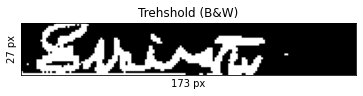

[(92, 26, 2, 1), (3, 21, 1, 1), (136, 16, 2, 1), (67, 6, 6, 5), (0, 0, 126, 27)]


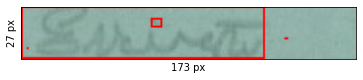

DATE 1002 116 102 27


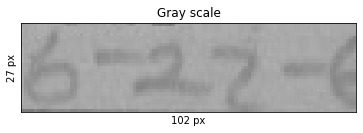

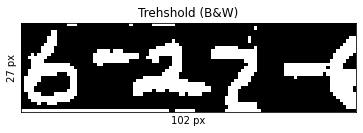

[(47, 26, 6, 1), (0, 26, 45, 1), (22, 8, 14, 5), (58, 7, 15, 20), (34, 5, 24, 17), (80, 4, 22, 22), (69, 4, 1, 2), (1, 2, 16, 23), (71, 1, 1, 1), (40, 0, 7, 1), (33, 0, 1, 1), (14, 0, 3, 1)]


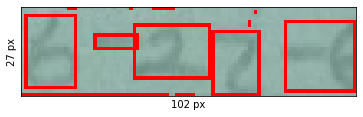

TRANSECT NO. 119 157 149 28


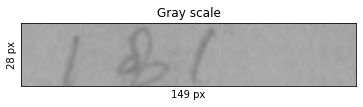

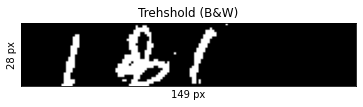

[(79, 25, 1, 2), (45, 25, 2, 1), (68, 13, 1, 1), (18, 5, 8, 23), (75, 2, 12, 25), (42, 1, 24, 27), (91, 0, 1, 1)]


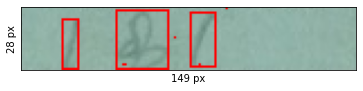

PLOT SIZE 275 160 93 26


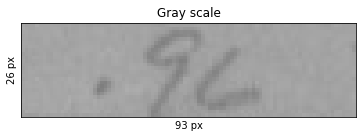

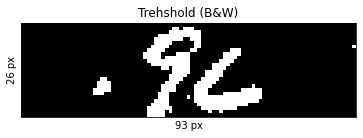

[(46, 20, 1, 1), (20, 15, 5, 5), (48, 7, 19, 18), (92, 6, 1, 1), (34, 1, 16, 25)]


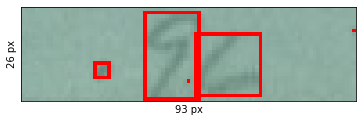

PLOT INTERVAL 375 160 174 29


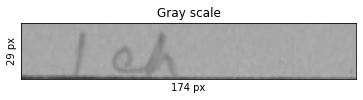

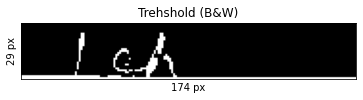

[(54, 21, 2, 1), (56, 18, 1, 1), (48, 13, 10, 13), (0, 5, 174, 24), (29, 5, 4, 19)]


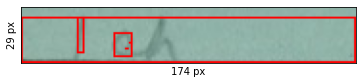

TYPE DESIGNATION 555 160 193 28


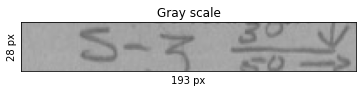

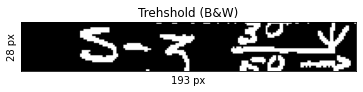

[(72, 27, 2, 1), (126, 22, 11, 6), (132, 20, 9, 4), (161, 19, 29, 9), (142, 19, 10, 9), (59, 12, 16, 5), (80, 7, 20, 21), (34, 3, 22, 20), (192, 0, 1, 1), (121, 0, 68, 18), (165, 0, 1, 1), (158, 0, 2, 1), (141, 0, 15, 9), (125, 0, 13, 13), (123, 0, 1, 1), (119, 0, 1, 1), (113, 0, 1, 1), (105, 0, 4, 1), (98, 0, 2, 1), (87, 0, 3, 1), (78, 0, 3, 1)]


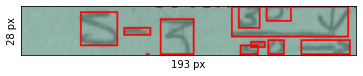

KIND OF LIVESTOCK 752 162 172 28


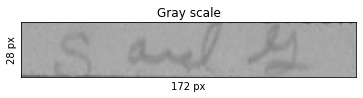

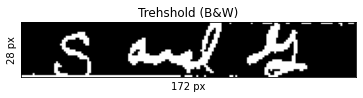

[(110, 27, 1, 1), (107, 27, 2, 1), (94, 27, 1, 1), (90, 27, 1, 1), (84, 27, 4, 1), (0, 5, 82, 23), (168, 0, 3, 1), (163, 0, 2, 2), (154, 0, 6, 1), (144, 0, 5, 1), (136, 0, 2, 1), (116, 0, 31, 28), (124, 0, 5, 1), (118, 0, 1, 1), (107, 0, 1, 1), (55, 0, 48, 26)]


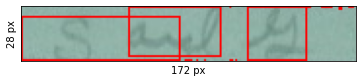

SLOPE 928 164 69 25


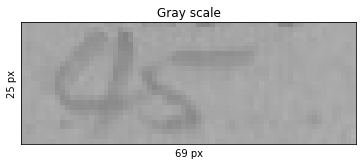

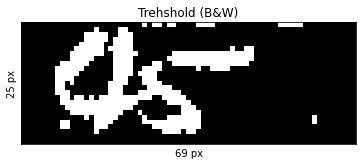

[(8, 20, 2, 2), (60, 19, 1, 2), (30, 5, 18, 5), (7, 1, 30, 22), (53, 0, 5, 1), (36, 0, 4, 1), (30, 0, 2, 1), (27, 0, 2, 1), (25, 0, 1, 1)]


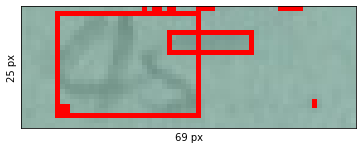

ASPECT 1003 167 100 24


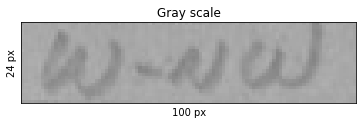

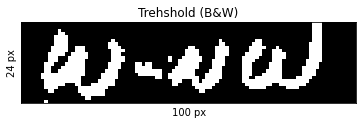

[(7, 23, 1, 1), (34, 12, 8, 5), (44, 10, 1, 2), (44, 5, 18, 16), (6, 2, 25, 21), (66, 0, 24, 20)]


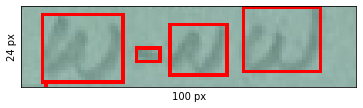

LOCATION 120 206 876 34


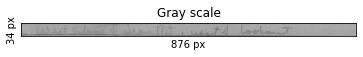

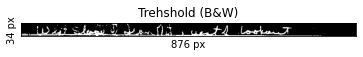

[(782, 33, 3, 1), (774, 33, 6, 1), (764, 33, 9, 1), (213, 33, 1, 1), (179, 33, 2, 1), (170, 33, 1, 1), (154, 33, 1, 1), (137, 33, 1, 1), (130, 33, 2, 1), (107, 33, 1, 1), (97, 33, 6, 1), (0, 33, 19, 1), (693, 31, 1, 1), (0, 28, 19, 3), (568, 26, 2, 2), (298, 26, 1, 1), (319, 25, 3, 2), (388, 24, 2, 2), (150, 21, 1, 3), (483, 20, 1, 1), (87, 18, 1, 1), (234, 16, 10, 10), (109, 15, 2, 1), (765, 14, 1, 1), (87, 14, 3, 2), (112, 13, 8, 8), (104, 13, 3, 2), (135, 12, 13, 10), (393, 11, 1, 2), (382, 10, 11, 11), (206, 10, 1, 1), (141, 10, 9, 3), (114, 10, 1, 1), (196, 9, 1, 2), (42, 8, 3, 7), (575, 7, 133, 24), (279, 6, 4, 8), (213, 6, 3, 2), (234, 5, 1, 1), (223, 5, 2, 2), (205, 5, 3, 4), (115, 5, 2, 3), (95, 5, 1, 2), (387, 4, 2, 3), (227, 4, 1, 1), (199, 4, 3, 3), (21, 4, 741, 30), (194, 2, 1, 1), (277, 0, 4, 5), (237, 0, 16, 15)]


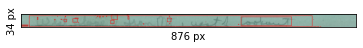

ELEVATION 1002 214 101 26


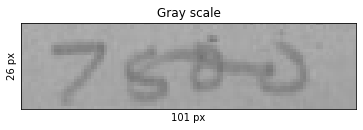

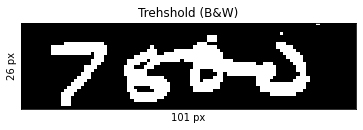

[(9, 6, 17, 19), (31, 4, 56, 20), (78, 3, 1, 1), (89, 0, 1, 1)]


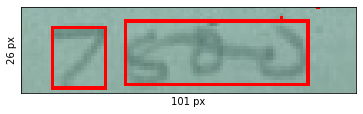

In [41]:
fields = grab_fields_coords("all_fields.json")['fields']
form = cv2.imread("highRes_ForestService.jpg")
i = 1
for field in fields:
    name = field['field']
    x = field['coord_pixel'][0]
    y = field['coord_pixel'][1]
    w = field['width']
    h = field['height']
    print(name, x, y, w, h)
    
    form_field = form[y:y+h, x:x+w]
    cv2.imwrite(f"/home/jsv/Documents/ForestProject/test/char_detection/output/field_{i}.jpg", form_field)
    i += 1
    
    bw_img = bw(form_field, show=True)
    
    # ROI
    
    ctrs, hier = cv2.findContours(bw_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    
    form_field_copy = form_field.copy()
    print(rects)
    for rect in rects:
        
        rx, ry, rw, rh = rect
        form_field_copy = cv2.rectangle(form_field_copy, rect, (0, 0, 255), 1)
    show_image(form_field_copy)
    
    
